In [12]:
import os

import matplotlib.pyplot as plt
import random
from pennylane import numpy as np
from tqdm import tqdm
#from qbmqsp.qbm import QBM
from qbmqsp.utils import construct_multi_fcqbm_pauli_strings
from gen_data import xxz_gibbs_state, basis_encoding, gen_boltzmann_dist, gen_discrete_gauss_dist
from qbmqsp.src.utils import import_dataset, split_dataset_labels, split_data
from sklearn.metrics import (accuracy_score, confusion_matrix, f1_score,
                             precision_score, recall_score)
import scipy.linalg as spl

import pennylane as qml
from pennylane import numpy as np
from pennylane.pauli.utils import string_to_pauli_word

from qbmqsp.hamiltonian import Hamiltonian
from qbmqsp.qsp_phase_engine import QSPPhaseEngine
from qbmqsp.qevt import QEVT
from qbmqsp.rel_ent import relative_entropy



import itertools

#DATASET_PATH3='C:/Users/ge84gac/datasets/o7_c5_d2_p200_1.npy'
DATASET_PATH2='C:/Users/ge84gac/Downloads/QBM-Anomaly-Detection-version-paper/QBM-Anomaly-Detection-main/src/datasets/l_o7_c5_d3_p200_v1.npy'
DATASET_PATH = 'C:/Users/ge84gac/QBM-anomaly-detection/src/datasets/l_o6_c10_d3_p1000_2.npy'   # Give dataset path
CLUSTER = 5

In [13]:
# Function returning the hamilatonian form for the restriceted boltzmann machine

In [14]:
def generate_pauli_strings_tfim(num_qubits,n_visible,restricted=True):
    """
    Generate Pauli strings for a transverse field Ising model as a 
    restricted boltzmann machine with no visible-visible connecions.
    
    Parameters:
    num_qubits (int): Number of qubits in the quantum Boltzmann machine.
    n_visible (int): Number if visible units.
    
    Returns:
    list: List of Pauli strings representing the Hamiltonian.
    """
    pauli_strings = []

    # Local transverse field terms (X_i)
    for i in range(num_qubits):
        pauli_string = ['I'] * num_qubits
        pauli_string[i] = 'Z'
        pauli_strings.append(''.join(pauli_string))

    # Interaction terms (Z_i Z_j)
    for i, j in itertools.combinations(range(num_qubits), 2):
        if restricted:
            if i<n_visible and j>=n_visible:
                pauli_string = ['I'] * num_qubits
    
                pauli_string[i] = 'Z'
                pauli_string[j] = 'Z'
                pauli_strings.append(''.join(pauli_string))
        else:
            if i<n_visible:
                pauli_string = ['I'] * num_qubits
    
                pauli_string[i] = 'Z'
                pauli_string[j] = 'Z'
                pauli_strings.append(''.join(pauli_string))       
    return pauli_strings

generate_pauli_strings_tfim(7,3,False)   

['ZIIIIII',
 'IZIIIII',
 'IIZIIII',
 'IIIZIII',
 'IIIIZII',
 'IIIIIZI',
 'IIIIIIZ',
 'ZZIIIII',
 'ZIZIIII',
 'ZIIZIII',
 'ZIIIZII',
 'ZIIIIZI',
 'ZIIIIIZ',
 'IZZIIII',
 'IZIZIII',
 'IZIIZII',
 'IZIIIZI',
 'IZIIIIZ',
 'IIZZIII',
 'IIZIZII',
 'IIZIIZI',
 'IIZIIIZ']

In [30]:
import seaborn as sns
def evaluate_qbm(qbm,testing_dataset,cluster,plot=False):


    #training_data=numpy.expand_dims(training_data[:,0],axis=1)
    outliers = qbm.get_binary_outliers(
    dataset=testing_dataset, outlier_index=cluster+1)

    #outliers=numpy.expand_dims(outliers[:,0],axis=1)
    

    points = qbm.get_binary_cluster_points(
    dataset=testing_dataset, cluster_index=cluster)

    #points=numpy.expand_dims(points[:,0],axis=1)
    #print(points)
    predict_points_cluster = np.zeros(len(points), dtype=int)
    predict_points_outliers = np.zeros(len(outliers), dtype=int)
    qbm.calculate_outlier_threshold(.95)
    print("Outlier threshold: ", qbm.outlier_threshold)
    print("Calculate outlier Energy")

    testing_data, testing_labels = split_dataset_labels(testing_dataset)
#testing_data=numpy.expand_dims(testing_data[:,0],axis=1)

    outlier_energy = []
    for index, outlier in enumerate(tqdm(outliers), 0):
        outlier = np.reshape(outlier, (qbm.dim_input))
        predict_points_outliers[index], this_outlier_energy = qbm.predict_point_as_outlier(
            outlier)
        outlier_energy.append(this_outlier_energy)
    outlier_energy = np.array(outlier_energy)

    o = outlier_energy.reshape((outlier_energy.shape[0]))

    print("Calculate cluster energy")
    cluster_point_energy = []

    for index, point in enumerate(tqdm(points), 0):
        point = np.reshape(point, (qbm.dim_input))
        predict_points_cluster[index], this_cluster_point_energy = qbm.predict_point_as_outlier(
        point)
        cluster_point_energy.append(this_cluster_point_energy)
    cluster_point_energy = np.array(cluster_point_energy)

    c = cluster_point_energy.reshape((cluster_point_energy.shape[0]))

    title='test'
#qbmqsp.src.utils.save_output(title="cluster_" + title, object=c)
#QBM.plot_energy_diff([o, c], qbm.outlier_threshold, title + ".pdf")

#QBM.plot_hist(c, o, qbm.outlier_threshold, "qbm_hist" + ".pdf")

########## OUTLIER CLASSIFICATION ##########
    print('Outlier classification: Results...')
    predict_points = np.concatenate(
        (predict_points_cluster, predict_points_outliers))

    print("Predicted points test: ", predict_points)

    true_points = np.concatenate(
        (np.zeros_like(cluster_point_energy), np.ones_like(outlier_energy)))

    accuracy, precision, recall = accuracy_score(true_points, predict_points), precision_score(
        true_points, predict_points), recall_score(true_points, predict_points)
    f1 = f1_score(true_points, predict_points)
    tn, fp, fn, tp = confusion_matrix(
        true_points, predict_points, labels=[0, 1]).ravel()

    print(f'Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1-Score: {f1}, \nNum True Negative: {tn}, Num False Negative: {fn}, Num True Positive: {tp}, Num False Positive: {fp}')

#print(f'Wallclock time: {(end-start):.2f} seconds')
    lab=cluster
    print("Outlier threshold: ", qbm.outlier_threshold)
    print("Average clusterpoint energy: ", np.average(cluster_point_energy))
    print("Outlier energy: ", outlier_energy)
    
    if plot==True:
        plt.figure()
        plt.title('Test Dataset')
        sns.scatterplot(x=testing_data[:,0],y=testing_data[:,1])
        sns.scatterplot(x=testing_data[:,0][testing_labels>lab],y=testing_data[:,1][testing_labels>lab], c='r',palette='coolwarm')
        
    #plt.title('Predicted Points')
    #sns.scatterplot(x=testing_data[:,0],y=testing_data[:,1], hue=predict_points,palette='coolwarm')
    return precision,recall,f1

class QBM():
    """Quantum Boltzmann machine (QBM) based on quantum signal processing.

    Parameters
    ----------
    β, enc:
        Same as attributes.
    h, θ:
        See qbmqsp.hamiltonian.Hamiltonian
    δ, polydeg:
        See qbmqsp.qsp_phase_engine.QSPPhaseEngine

    Attributes
    ----------
    β : float
        Inverse temperature.
    enc : str in {'general', 'lcu'}
        Unitary block encoding scheme.
    H : qbmqsp.hamiltonian.Hamiltonian
        Constructed from parameters (h, θ).
    qsp : qbmqsp.qsp_phase_engine.QSPPhaseEngine
        Constructed from parameters (δ, polydeg).
    qevt : qbmqsp.qevt.QEVT
        Quantum eigenvalue transform to realize matrix function f(A) = exp(- τ * |A|). Updated after each training epoch.
    observables : qml.operation.Observable
        Observables w.r.t which the QBM is measured to optimize via gradient descent.
    aux_wire, enc_wires, sys_wires, env_wires : list[int]
        Quantum register wires of quantum circuit that prepares and measures the QBM.
    """
    
    
    
    
    
    def __init__(self,data,h: list[str], θ: np.ndarray[float], enc: str, δ: float, polydeg: int, β: float, hnodes,epochs=1,restricted=True) -> None:
        if β < 0:
            raise ValueError("__init__: β must not be negative.")
        
        self.epochs=epochs
        self.β = β
        self.enc = enc
        self.H = Hamiltonian(h, θ)
        self.qsp = QSPPhaseEngine(δ, polydeg)
        self.qevt = self._construct_qevt()
        self.aux_wire, self.enc_wires, self.sys_wires, self.env_wires = self._construct_wires()
        self.observables = self._construct_obervables()
        
        self.encoded_data, bits_input_vector, num_features = self.binary_encode_data(data, use_folding=True)
        self.dim_input = bits_input_vector * num_features
        self.quantile=0.95
        self.dim_input=n_visible
        self.n_hidden_nodes=hnodes
        
        self.qubits=self.dim_input+self.n_hidden_nodes
        
        self.restricted=restricted

        if self.restricted:
            self.weights_visible_to_hidden=np.reshape(self.H.θ[self.dim_input+self.n_hidden_nodes:],(self.dim_input,self.n_hidden_nodes))
            self.biases_hidden=self.H.θ[self.dim_input:self.dim_input+self.n_hidden_nodes]
            self.biases_visible=self.H.θ[:self.dim_input]
        else:
            
            self.weights_visible_to_visible,self.weights_visible_to_hidden=self.get_weights(self.H.θ)
            self.biases_hidden=self.H.θ[self.dim_input:self.dim_input+self.n_hidden_nodes]
            self.biases_visible=self.H.θ[:self.dim_input]
        

    def get_binary_cluster_points(self,dataset, cluster_index: int) -> np.ndarray:
        points = np.array([entry[:-1]
                           for entry in dataset if entry[-1] <= cluster_index])

        return self.binary_encode_data(points, use_folding=False)[0]
    
    def get_binary_outliers(self,dataset, outlier_index: int):
        outliers = np.array([entry[:-1]
                            for entry in dataset if entry[-1] >= outlier_index])

        return self.binary_encode_data(outliers, use_folding=False)[0]
  
    def binary_encode_data(self,data, use_folding=False):
        """ Encode a numpy array of form [[numpy.int64 numpy.int64] ...] into a
        list of form [[int, int, int, ...], ...].
        Example: encode [[107  73] [113  90] ...] to
        [[1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1],[1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0] .
        """

        # find out how many bits we need for each feature
        number_bits = len(np.binary_repr(np.amax(data)))
        number_features = data.shape[1]

        binary_encoded = ((data.reshape(-1, 1) & np.array(2 **
                          np.arange(number_bits-1, -1, -1))) != 0).astype(np.float32)
        if use_folding:
            return binary_encoded.reshape(len(data), number_features*number_bits), number_bits, number_features
        else:
            return binary_encoded.reshape(len(data), number_features, number_bits), number_bits, number_features
    
    
    def n_qubits(self, registers: str | set[str] = None) -> int:
        """Return number of qubits per registers.
        
        Parameters
        ----------
        registers : str | set[str]
            Quantum registers whose number of qubits should be returned.
            Must be an element from or a subset of {'aux', 'enc', 'sys', 'env'}.

        Returns
        -------
        n : int
            Number of qubits used per registers.
        """
        if registers is None:
            registers = {'aux', 'enc', 'sys', 'env'}
        elif type(registers) == str:
            registers = {registers}
        if not registers.issubset({'aux', 'enc', 'sys', 'env'}):
            raise ValueError("n_qubits: registers must be an element from or a subset of %r." % {'aux', 'enc', 'sys', 'env'})
        
        n = 0
        if 'env' in registers:
            n += self.qevt.n_qubits('sys')
        registers.discard('env')
        if len(registers) != 0:
            n += self.qevt.n_qubits(registers)
        return n

    def _generate_qsp_phases(self) -> np.ndarray[float]:
        τ = self.β / (1-self.qsp.δ) * self.H.θ_norm()
        φ = self.qsp.generate(τ)
        return φ

    def _construct_qevt(self) -> QEVT:
        φ = self._generate_qsp_phases()
        h_δ, θ_δ = self.H.preprocessing(self.qsp.δ)
        return QEVT(h_δ, θ_δ, self.enc, φ)
    
    def _construct_wires(self) -> tuple[list[int], list[int], list[int], list[int]]:
        wires = list(range(self.n_qubits()))
        aux_wire = wires[: self.n_qubits('aux')]
        enc_wires = wires[self.n_qubits('aux') : self.n_qubits({'aux', 'enc'})]
        sys_wires = wires[self.n_qubits({'aux', 'enc'}) : self.n_qubits({'aux', 'enc', 'sys'})]
        env_wires = wires[self.n_qubits({'aux', 'enc', 'sys'}) : self.n_qubits({'aux', 'enc', 'sys', 'env'})]
        return aux_wire, enc_wires, sys_wires, env_wires

    def _construct_obervables(self) -> list[qml.operation.Observable]:
        n_aux_enc = self.n_qubits({'aux', 'enc'})
        aux_enc_wires = self.aux_wire + self.enc_wires
        proj0 = qml.Projector( [0] * n_aux_enc, aux_enc_wires)

        new_sys_wires = list(range(self.n_qubits('sys')))
        wire_map = dict(zip(self.sys_wires, new_sys_wires))
        observables = [proj0] + [proj0 @ string_to_pauli_word(self.H.h[i], wire_map) for i in range(self.H.n_params)]
        return observables
    
    def _bell_circuit(self) -> None:
        for i, j in zip(self.sys_wires, self.env_wires):
            qml.Hadamard(i)
            qml.CNOT([i, j])

    def probabilistic(self):
        
        bit_strings=[]
        for i in range(2**(self.n_hidden_nodes+self.dim_input)):
        # Convert the number to its binary representation and pad with leading zeros
            bit_string = bin(i)[2:].zfill(self.n_hidden_nodes+self.dim_input)
             
            bit_list = np.array([int(bit) for bit in bit_string])
            bit_strings.append(bit_list) 
            
      
        sample = random.choices(bit_strings, k=1)

        for i,x in enumerate(sample[0]):
            if x==1:
                qml.PauliX(wires=[self.sys_wires[i]])
    
    def _prepare(self) -> None:
        self._bell_circuit()
        #self.probabilistic()
        self.qevt.circuit(self.aux_wire, self.enc_wires, self.sys_wires)
    
    def _measure(self) -> None:
        #return qml.sample(wires=self.aux_wire+self.enc_wires+self.sys_wires)
        return [qml.expval(self.observables[i]) for i in range(len(self.observables))]
    
    
    def get_sample(self,shots=1):
        dev = qml.device(dev_name,shots=shots, wires=self.n_qubits({'aux','enc','sys'}))
        @qml.qnode(dev)
        
        def quantum_circuit():
            
            self._prepare()
            return qml.sample(wires=self.aux_wire+self.enc_wires+self.sys_wires)
        
        sample=quantum_circuit()
        return sample
    
    def get_average_configuration_from_samples(self, samples: list, input_vector=None):
        ''' Takes samples from Annealer and averages for each neuron and connection
        '''

        # unclamped if input_vector == None
        unclamped = input_vector== None

        # biases (row = sample, column = neuron)
        np_samples = np.vstack(
            tuple([np.array(list(sample.values())) for sample in samples]))
        avgs_biases = np.average(np_samples, axis=0)
        avgs_biases_hidden = avgs_biases[self.dim_input:] if unclamped else avgs_biases
        avgs_biases_visible = avgs_biases[:
                                          self.dim_input] if unclamped else input_vector

        # weights
        avgs_weights_visible_to_hidden = np.zeros(
            self.weights_visible_to_hidden.shape)
        if not self.restricted:
            avgs_weights_visible_to_visible = np.zeros(
                self.weights_visible_to_visible.shape)
        for v in range(self.dim_input):
            # visible to hidden connections
            for h in range(self.n_hidden_nodes):
                x, y = (np_samples[:, v], self.dim_input +
                        h) if unclamped else (input_vector[v], h)
                avgs_weights_visible_to_hidden[v, h] = np.average(
                    x*np_samples[:, y])
            # visible to visible connections
            if not self.restricted:
                for v2 in range(v, self.dim_input):
                    x, y = (np_samples[:, v], np_samples[:, v2]) if unclamped else (
                        input_vector[v], input_vector[v2])
                    avgs_weights_visible_to_visible[v, v2] = np.average(x*y)

        if self.restricted:
            return avgs_biases_hidden, avgs_biases_visible, avgs_weights_visible_to_hidden, None
        else:
            return avgs_biases_hidden, avgs_biases_visible, avgs_weights_visible_to_hidden, avgs_weights_visible_to_visible

    def _compute_expvals(self) -> np.ndarray[float]:
        dev = qml.device(dev_name,wires=self.n_qubits({'aux','enc','sys','env'}))
        #dev = qml.device(dev_name, backend=backend,wires=self.n_qubits(),ibmqx_token=token)
        @qml.qnode(dev)
        
        def quantum_circuit():
            self._prepare()
            return self._measure()
        num_repetitions=1
        avg_measurements=np.zeros(self.H.n_params)
        for repetitions in range(num_repetitions):
            
            measurements = quantum_circuit()
            
            success_probabilty = measurements[0]
            
            
            qbm_expvals = measurements[1:] / success_probabilty
            
            avg_measurements+=qbm_expvals
            
            print(success_probabilty, "prob")
        
        
        avg_measurements=avg_measurements/float(num_repetitions)
        
       
        return avg_measurements
    
    def _loss_func(self, ρ0: np.ndarray[float], ρ1: np.ndarray[float]) -> float:
        return relative_entropy(ρ0, ρ1, check_state=True).item()
    
    def assemble(self) -> np.ndarray[float]:
        """Assemble QBM."""
        expH = spl.expm(-self.β * self.H.assemble())
        return expH / np.trace(expH)
    
    
    def get_energy(self,input_vector):
        input_vector=[input_vector]
        new_biases=self.biases_hidden+np.matmul(1-2*np.array(input_vector),self.weights_visible_to_hidden).flatten()
        
        
    # List to store all bit strings
        bit_strings=[]
        p=[]
    # There are 2^n bit strings of length n
        #print(new_biases)
        for i in range(2**self.n_hidden_nodes):
        # Convert the number to its binary representation and pad with leading zeros
            bit_string = bin(i)[2:].zfill(self.n_hidden_nodes)
             
            bit_list = np.array([1-2*int(bit) for bit in bit_string])
            bit_strings.append(bit_list) 
            p.append(np.exp(-self.β*np.dot(bit_list,new_biases)))

        p=np.array(p)
        probabilities=p/np.sum(p)
        sample = random.choices(bit_strings, weights=probabilities, k=1)

        return self.β*np.dot(sample,new_biases)
            

               

            
     
    
    def free_energy(self, input_vector):
        '''Function to compute the free energy'''

        # calculate hidden term
        
         
         
        hidden_term = self.get_energy(input_vector)

        # calculate visible_term
        # visible bias
        visible_term = self.β*np.dot(
            1-2*np.array(input_vector), self.H.θ[:self.dim_input]) #/beta
        
        

        return hidden_term + visible_term
    
    def calculate_outlier_threshold(self, quantile=0.95):
        self.quantile = quantile
        energies = np.apply_along_axis(
            self.free_energy, axis=1, arr=self.encoded_data)
        self.outlier_threshold = np.quantile(energies, self.quantile)
    
    
    
    
    
    def get_average_configurations(self,input_vector=None):
        '''
        Function for giving averge configurations of all qubits for the gibbs state of the system.
        Gives configuration over hidden units only, if input vector is clamped at a certain value.
       
    
        Parameters:
        input vector (np.ndarray)
        
    
        Returns:
        list: List of expectation values of hamilatonian terms.
        '''
        
        
        # unclamped values
        if input_vector is None:
            
            qbm_expvals=self._compute_expvals()
            
            return qbm_expvals
        
        # clamped values
        
        
        if self.restricted:
            self.weights_visible_to_hidden=np.reshape(self.H.θ[self.dim_input+self.n_hidden_nodes:],(self.dim_input,self.n_hidden_nodes))
            self.biases_hidden=self.H.θ[self.dim_input:self.dim_input+self.n_hidden_nodes]
            self.biases_visible=self.H.θ[:self.dim_input]
        else:
            
            self.weights_visible_to_visible,self.weights_visible_to_hidden=self.get_weights(self.H.θ)
            self.biases_hidden=self.H.θ[self.dim_input:self.dim_input+self.n_hidden_nodes]
            self.biases_visible=self.H.θ[:self.dim_input]
        
        input_vector=[input_vector]
        new_biases=self.biases_hidden+np.matmul(1-2*np.array(input_vector),self.weights_visible_to_hidden).flatten()
        #np.matmul(input_vector, self.weights_visible_to_hidden).flatten()
        
        Q_new=new_biases

        exp_vals=-np.tanh(self.β*new_biases)
        return exp_vals
            
        '''
        
        β, δ, θ_norm = self.β, 0.3, np.linalg.norm(Q_new, ord=1)
        τ = β * θ_norm / (1-δ)
        
        φ = self.qsp.generate(τ)
        #del qsp_phase_engine
         
      
        # New energy configuration only for hidden units
        h=generate_pauli_strings_tfim(self.n_hidden_nodes,self.n_hidden_nodes)
        
        h_δ = h + [self.n_hidden_nodes * 'I']
        θ_δ = np.append(Q_new * (1-δ)/(2*θ_norm), (1+δ)/2)
        encoding='general' 
        qevt = QEVT(h_δ, θ_δ, encoding, φ)
        
        
        
        n_aux, n_enc, n_sys = qevt.n_qubits({'aux'}), qevt.n_qubits({'enc'}), qevt.n_qubits({'sys'})
        wires = list(range(n_aux + n_enc + 2*n_sys))
        aux_wire = wires[: n_aux]
        enc_wires = wires[n_aux : n_aux+n_enc]
        sys_wires = wires[n_aux+n_enc : n_aux+n_enc+n_sys]
        env_wires=wires[n_aux+n_enc+n_sys:]
        
        new_sys_wires = list(range(n_sys))
        wire_map = dict(zip(self.sys_wires, new_sys_wires))
        proj0 = qml.Projector( [0] * (n_aux+n_enc), aux_wire+enc_wires)
        observables = [proj0] + [proj0 @ string_to_pauli_word(h[i], wire_map) for i in range(len(h))]
        
        
        dev = qml.device(dev_name, wires=n_aux+n_enc+2*n_sys)
        #dev = qml.device(, backend=backend,wires=n_aux+n_enc+2*n_sys,ibmqx_token=token)
        @qml.qnode(dev)
        
        
        def qevt_circuit():
            for i, j in zip(sys_wires, env_wires):
                qml.Hadamard(i)
                qml.CNOT([i, j])
            qevt.circuit(aux_wire, enc_wires, sys_wires)
            return [qml.expval(observables[i]) for i in range(len(observables))]
       
        measurements = qevt_circuit()
        success_probabilty = measurements[0]
        qbm_expvals = measurements[1:] / success_probabilty    
        
        return qbm_expvals
    
        '''
            
        
        
    def train_for_one_iteration(self, batch, learning_rate):

        errors = 0
        #errors_biases_visible = 0
        #errors_weights_visible_to_hidden = 0
        #if not self.restricted:
          #  errors_weights_visible_to_visible = 0

        for i,input_vector in enumerate(batch):
            
            
            if i==0:
                unclamped_config = self.get_average_configurations() 
                print(unclamped_config)
            
            clamped_config = self.get_average_configurations(input_vector) # has only expectations over hidden units
            
            # avgs_weights_visible_to_visible_clamped only has a value if not restricted
            print(clamped_config)
            
            # Getting averages for all qubits , avg_visible=input_vector
            
            full_clamped_config=np.zeros_like(unclamped_config)
            
            full_clamped_config[:self.dim_input]=1+(-2)*input_vector   
            full_clamped_config[self.dim_input:self.dim_input+self.n_hidden_nodes]=clamped_config
            
            pos_neg=1-2*input_vector
            if self.restricted:
                
                
                full_clamped_config[self.dim_input+self.n_hidden_nodes:]=np.kron(pos_neg,clamped_config)
            
            else:
                
                
                
                visible=list(pos_neg[j]*pos_neg[i] for j in range(len(pos_neg)) for i in range(j+1,len(pos_neg)))
                hidden=np.kron(pos_neg,clamped_config)
                for i in range(1,self.dim_input+1):
                    for j in range(self.n_hidden_nodes):
                        visible.insert((i-1)*self.n_hidden_nodes+(i)*(self.dim_input-1)-(i-1)+j,hidden[self.n_hidden_nodes*(i-1)+j])
                full_clamped_config[self.dim_input+self.n_hidden_nodes:]=np.array(visible)
            
            errors += full_clamped_config - unclamped_config
            
            
            
            
            
            
            

        errors /= batch.shape[0]
        
        self.H.θ = self.H.θ - learning_rate * errors
                
        self.qevt = self._construct_qevt()
                
       
        
        
        return np.average(errors[:self.dim_input]**2)
    
    
    
    
    def train_model(self, batch_size=8, learning_rate=0.005,save=False):
        
        data = self.encoded_data
        
        weights=[]
        batch_num = data.shape[0] // batch_size
        diff = data.shape[0] % batch_size
        if diff:
            
        
            data = data[:-diff]
            last_batch = data[data.shape[0] - diff:]
        
        
        
        batches = np.vsplit(data, batch_num)
        
        if diff:
            batches.append(last_batch)
              
        losses=[]
        
        for epoch in range(1, self.epochs+1):
            print(f'Epoch {epoch}')
            batch_errors = None
            batchnum = 1
            errors_epoch=[]
            for batch in tqdm(batches):
                    print(batch)
                    errors = self.train_for_one_iteration(batch, learning_rate)
                    print(errors)
                    if type(batch_errors) is np.ndarray:
                        batch_errors = np.hstack((batch_errors, errors))
                    else:
                        batch_errors = errors
                    #self.save_weights(
                        #f'e{epoch}_b{batchnum}_{self.paramstring}')
                    batchnum += 1
               
                    #self.save_weights(
                     #   f'e{epoch}_b{batchnum}_{self.paramstring}')
                    #raise e
                    errors_epoch.append(errors)
            
            losses.append(errors_epoch)
            weights.append(self.H.θ)
            if save==True:
                try:
                    np.savez(f'./epoch{epoch}_weights_h{self.n_hidden_nodes}_v{self.dim_input}_lr{self.learning_rate}_e{self.epochs}',self.H.θ)
                    np.savez(f'./epoch{epoch}_losses_h{self.n_hidden_nodes}_v{self.dim_input}_lr{self.learning_rate}_e{self.epochs}',errors_epoch)
                except:
                    print('error_saving')
        self.calculate_outlier_threshold(self.quantile)
        
        
        
        return losses, weights 
    
    #self.error_container.add_error(batch_errors)
        #self.error_container.plot("qbm_errors" + self.paramstring)
        #self.save_weights(title="final_weights_qbm" + self.paramstring)
        # make list of values of the error dicts
        
        #self.calculate_outlier_threshold(self.quantile)
       
    def predict_point_as_outlier(self, input):
        energy = self.free_energy(input)
        if energy >= self.outlier_threshold:
            return 1, energy
        return 0, energy
        
    
    def get_weights(self,Q):
        weights_vh_vv=list(Q[self.dim_input+self.n_hidden_nodes:])
            
        for i in range(1,self.dim_input+1):
            for j in range(i):
                weights_vh_vv.insert((self.dim_input+self.n_hidden_nodes)*(i-1)+j,0)
            
        weights_vh_vv=np.array(weights_vh_vv)
        weights_visible_to_visible=weights_vh_vv.reshape(self.dim_input,self.dim_input+self.n_hidden_nodes)[:,0:self.dim_input]
        weights_visible_to_hidden=weights_vh_vv.reshape(self.dim_input,self.dim_input+self.n_hidden_nodes)[:,self.dim_input:]
    
        return weights_visible_to_visible,weights_visible_to_hidden
    
         
        
     
    

    

In [67]:
PATH= '../../datasets/l_o8_c4_d2_p200_1.npy'

CLUSTER=3
np.random.seed(seed=1)
#dev_name='qiskit.ibmq'
data = import_dataset(PATH)
training_dataset, testing_dataset = split_data(data, CLUSTER)
training_data, training_labels = split_dataset_labels(training_dataset)


import numpy
#training_data=numpy.expand_dims(training_data[:,0],axis=1)
#training_data=training_data[0::]
n_hidden_units=1
n_visible=8
n_qubits = n_visible+n_hidden_units

restricted=False
h = generate_pauli_strings_tfim(n_qubits,n_visible,restricted)
print(h)
nparams = len(h)

θ_init = np.random.rand(nparams)/nparams#np.loadtxt('./weights_7_3_un.txt')
enc = 'general'
δ = 0.3
polydeg = 10
β = 1.0
learning_rate = 0.005
epochs = 4


dev_name='default.qubit'
#dev_name='lightning.qubit'

qbm = QBM(training_data,h, θ_init, enc, δ, polydeg, β,n_hidden_units,epochs,restricted)

#errors,weights=qbm.train_model(3,learning_rate)

['ZIIIIIIII', 'IZIIIIIII', 'IIZIIIIII', 'IIIZIIIII', 'IIIIZIIII', 'IIIIIZIII', 'IIIIIIZII', 'IIIIIIIZI', 'IIIIIIIIZ', 'ZZIIIIIII', 'ZIZIIIIII', 'ZIIZIIIII', 'ZIIIZIIII', 'ZIIIIZIII', 'ZIIIIIZII', 'ZIIIIIIZI', 'ZIIIIIIIZ', 'IZZIIIIII', 'IZIZIIIII', 'IZIIZIIII', 'IZIIIZIII', 'IZIIIIZII', 'IZIIIIIZI', 'IZIIIIIIZ', 'IIZZIIIII', 'IIZIZIIII', 'IIZIIZIII', 'IIZIIIZII', 'IIZIIIIZI', 'IIZIIIIIZ', 'IIIZZIIII', 'IIIZIZIII', 'IIIZIIZII', 'IIIZIIIZI', 'IIIZIIIIZ', 'IIIIZZIII', 'IIIIZIZII', 'IIIIZIIZI', 'IIIIZIIIZ', 'IIIIIZZII', 'IIIIIZIZI', 'IIIIIZIIZ', 'IIIIIIZZI', 'IIIIIIZIZ', 'IIIIIIIZZ']

Starting MATLAB engine.. Done.


Stopping MATLAB engine ... Done.



In [41]:
np.savez('weights_8_2_un_3_epochs',weights)

[ 3  1  1  0  2  0  3  2  1  1  2  3  0  2  0  2  1  0  2  2  0  1  2  3
  2  2  2  0  2  3  0  3  1  3  3  0  1  2  1  1  2  2  1  0  3  2  3  3
  1  1  3  0  1  0  0  0  1  3  2  3  3  3  1  2  1  1  0  1  0  1  0  3
  1  1  1  1  1  3  1  3  0  1  0  1  0  3  0  2  2  3  0  1  2  2  3  1
  1  3  3  2  3  1  3  0  2  1  3  3  2  3  1  1  3  0  2  0  2  3  2  2
  1  0  0  3  2  1  3  2  2  0  3  3  2  2  2  3  1  0  0  2  3  0  2  1
  1  0  1  1  0  2  1  3  2  1  0  1  2  2  0  2  0  1  3  0  1  2  0  2
  2  0  3  1  8  0  2  3  3  2  0  0  0  2  0  2  0  2  3  0  0  0  2  2
  2  3  1  1  1  3  2  3  2  3  0  1  0  2  0  4  1  2  0  2  3  2  3  1
  3  1  0  0  0  2  1  1  2  2  1  1  0  2  3  3  2  1  2  0  2  3  3  0
  2  1  3  3  3  0  0  3  1  1  1  3  0  2  0  2  1  0  3  0  1  3  0  3
  2  0  0  0  1  0  3  3  3  3  0  1  2  1  2  3  3  2  3  3  0  1  2  0
  0  0  0  0  0  2  3  3  3  1  5  3  1  3  1  0  3  0  3  1  3  3  2  1
  2  2  2  1  0  1  2  3  3  1  2  2  1  2  1  1  0

<Axes: >

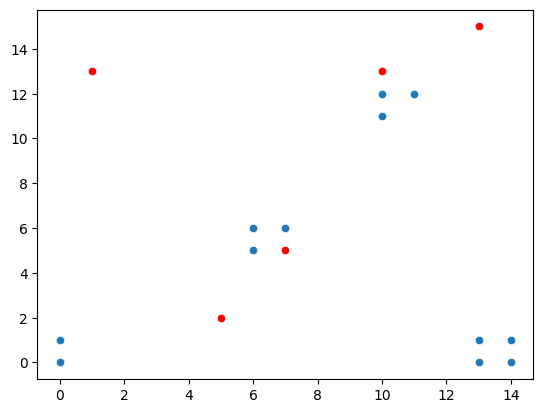

In [84]:

CLUSTER=3
PATH= '../../datasets/l_o8_c4_d2_p200_1.npy'
data = import_dataset(PATH)
training_dataset, testing_dataset = split_data(data, CLUSTER)

training_data, training_labels = split_dataset_labels(training_dataset)
testing_data,testing_labels=split_dataset_labels(testing_dataset)

print(testing_labels)
import seaborn as sns
import numpy
#sns.histplot(testing_data[:,0])
plt.figure()
#training_labels
lab=3
#sns.scatterplot(x=training_data[:,0],y=training_data[:,1])
#sns.scatterplot(c='r',x=training_data[:,0][training_labels==lab],y=training_data[:,1][training_labels==lab])

sns.scatterplot(x=testing_data[:,0],y=testing_data[:,1])
sns.scatterplot(c='r',x=testing_data[:,0][testing_labels>lab],y=testing_data[:,1][testing_labels>lab])

(<Figure size 6400x2300 with 1 Axes>, <Axes: >)

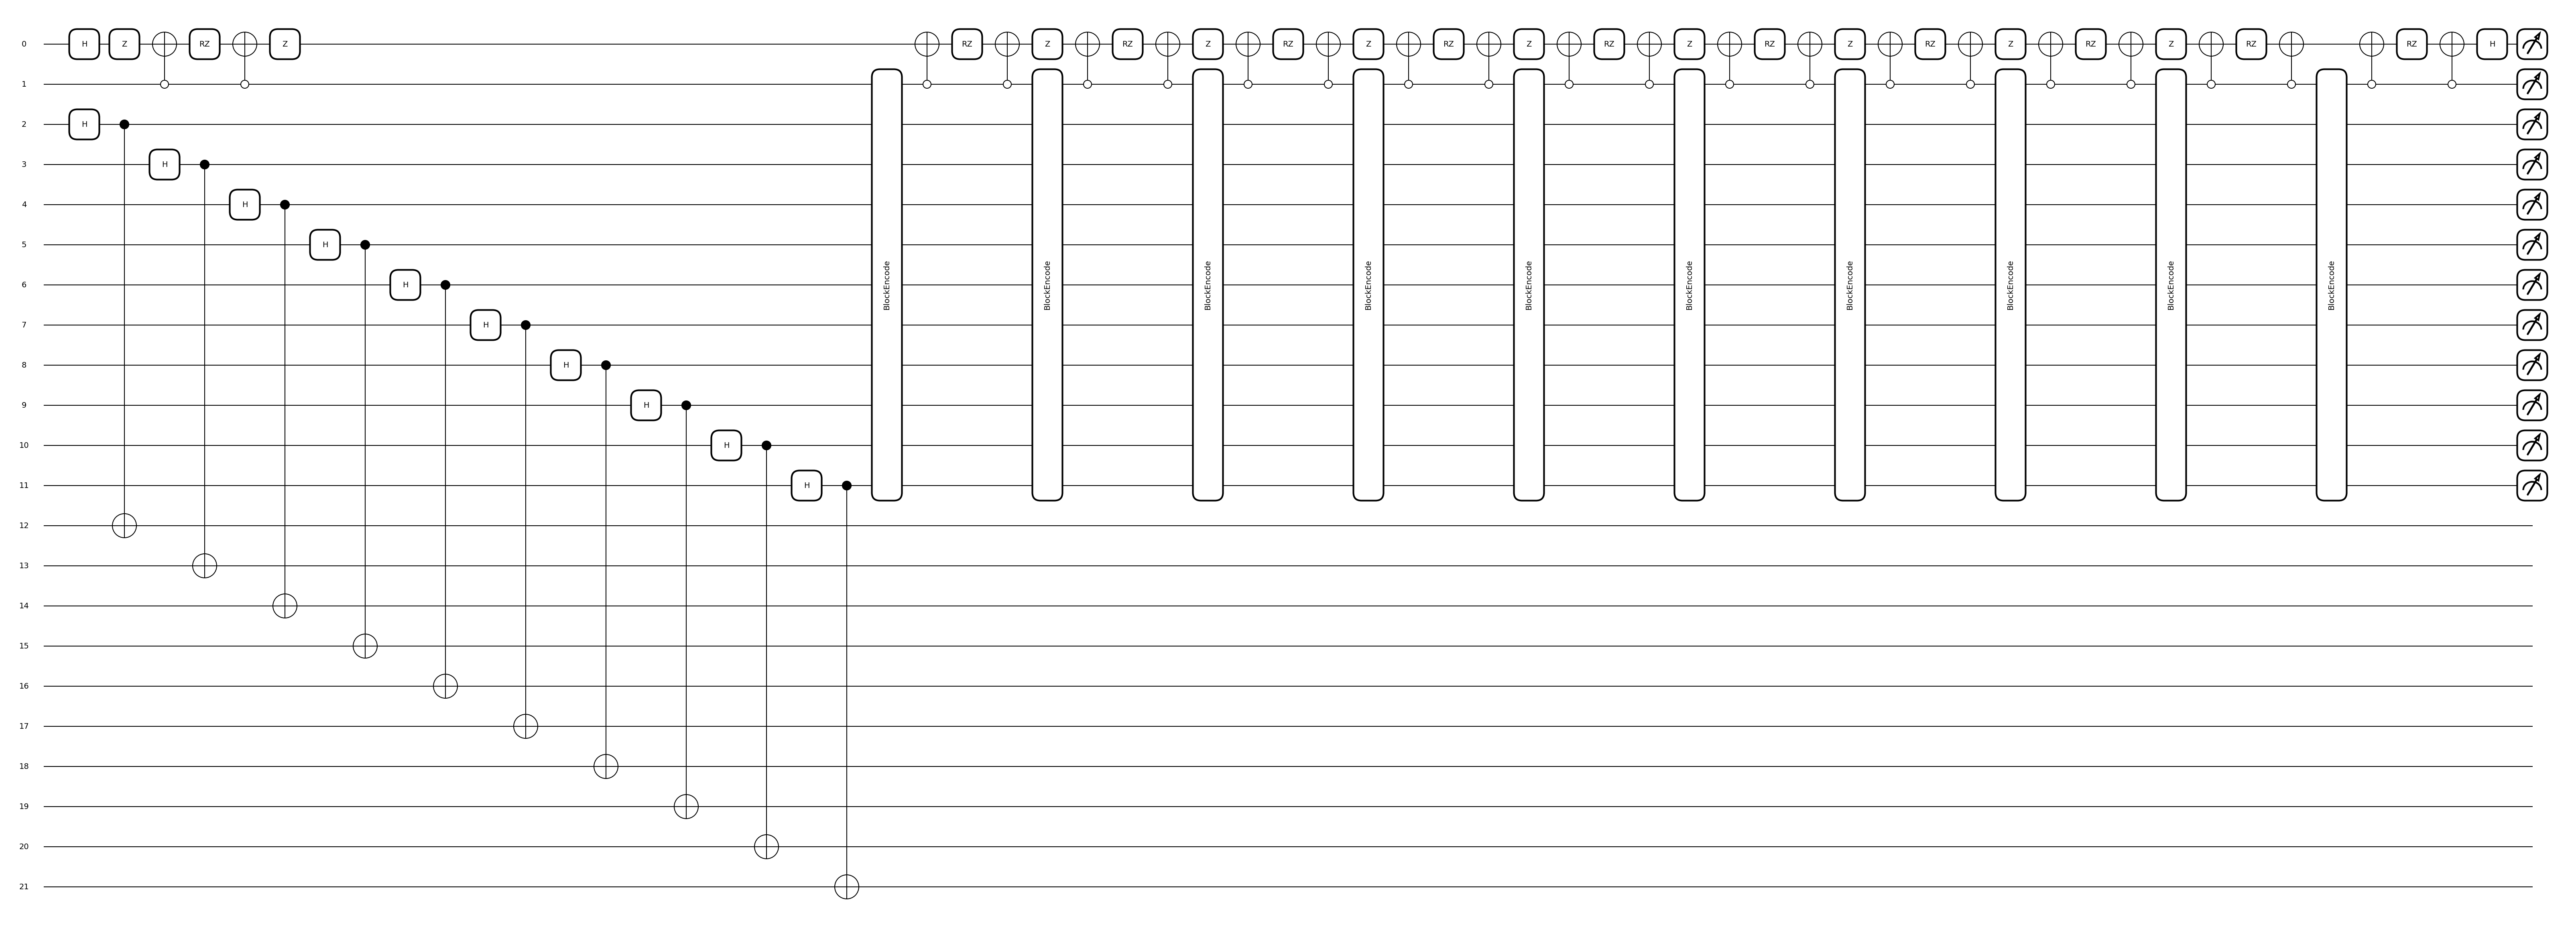

In [114]:
dev = qml.device(dev_name, wires=qbm.n_qubits({'aux','enc','sys'}))
        #dev = qml.device(dev_name, backend=backend,wires=self.n_qubits(),ibmqx_token=token)
@qml.qnode(dev)
def quantum_circuit():
    qbm._prepare()
    return qbm._measure()

qml.draw_mpl(quantum_circuit)()

[[[1. 1. 0. 1.]
  [1. 1. 1. 1.]]

 [[0. 1. 0. 1.]
  [0. 0. 1. 0.]]

 [[1. 0. 1. 0.]
  [1. 1. 0. 1.]]

 [[0. 0. 0. 1.]
  [1. 1. 0. 1.]]

 [[0. 1. 1. 1.]
  [0. 1. 0. 1.]]]
[-1.42916038]
[-1.10425837]
[-1.42916038]
[-1.10425837]
[-3.77741756]
[0.9062684]
[-1.05642846]
[0.9062684]
[-2.08247181]
[-3.77741756]
[-1.05642846]
[-1.42916038]
[-3.83625577]
[-2.08247181]
[0.067896]
[-2.08247181]
[-1.05642846]
[-1.16309659]
[0.53353648]
[-1.42916038]
[-1.42916038]
[-1.42916038]
[-3.83625577]
[-1.05642846]
[-1.16309659]
[-1.05642846]
[0.53353648]
[-1.05642846]
[-3.77741756]
[-1.10425837]
[-1.05642846]
[-1.16309659]
[-1.42916038]
[-3.83625577]
[-1.10425837]
[-2.08247181]
[-1.05642846]
[-3.83625577]
[-1.05642846]
[-3.77741756]
[-2.08247181]
[-3.83625577]
[-1.05642846]
[0.53353648]
[-1.16309659]
[0.067896]
[-1.05642846]
[-3.77741756]
[-3.83625577]
[-1.05642846]
[-1.42916038]
[-1.05642846]
[-2.08247181]
[0.9062684]
[-3.83625577]
[-1.42916038]
[-1.10425837]
[-1.42916038]
[-1.05642846]
[-1.05642846]
[-1.4

100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 1155.46it/s]


[1.60755012]
[-0.07011734]
[-1.11526668]
[-0.54113038]
[0.53353648]
Calculate cluster energy


 56%|███████████████████████████████████████████▉                                  | 225/399 [00:00<00:00, 1124.28it/s]

[-1.05642846]
[-1.05642846]
[-3.83625577]
[-3.77741756]
[-1.10425837]
[-1.10425837]
[0.53353648]
[-3.83625577]
[-1.05642846]
[0.9062684]
[-1.16309659]
[0.9062684]
[-1.05642846]
[-1.05642846]
[-1.05642846]
[0.067896]
[-3.83625577]
[-1.05642846]
[-1.05642846]
[-2.08247181]
[-2.08247181]
[-1.42916038]
[-1.05642846]
[-3.83625577]
[-2.08247181]
[-1.42916038]
[-1.42916038]
[-1.10425837]
[-2.14131002]
[-2.08247181]
[-1.42916038]
[-1.10425837]
[0.067896]
[0.53353648]
[-3.77741756]
[-1.42916038]
[2.03059287]
[-1.16309659]
[-1.05642846]
[-1.05642846]
[2.03059287]
[-2.14131002]
[-1.05642846]
[-2.08247181]
[-1.16309659]
[-2.08247181]
[-1.05642846]
[-3.77741756]
[-1.16309659]
[-1.05642846]
[-1.42916038]
[-1.05642846]
[-1.10425837]
[-3.77741756]
[-3.77741756]
[-1.16309659]
[-2.08247181]
[-3.77741756]
[-1.05642846]
[-3.83625577]
[-3.77741756]
[0.067896]
[0.9062684]
[0.9062684]
[0.9062684]
[-1.42916038]
[-1.05642846]
[-3.77741756]
[-3.77741756]
[-1.05642846]
[-1.42916038]
[-1.05642846]
[-1.05642846]
[

100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1058.21it/s]


[-3.83625577]
[-1.05642846]
[-3.77741756]
[-1.05642846]
[0.067896]
[-3.77741756]
[-1.05642846]
[-3.77741756]
[-3.83625577]
[-1.42916038]
[-1.16309659]
[-2.08247181]
[0.9062684]
[-1.05642846]
[-1.05642846]
[-3.77741756]
[-3.83625577]
[-1.16309659]
[-3.77741756]
[-2.14131002]
[-1.05642846]
[-1.42916038]
[-3.77741756]
[-1.16309659]
[-1.10425837]
[-1.05642846]
[-3.83625577]
[-1.42916038]
[-1.16309659]
[-3.83625577]
[0.53353648]
[-3.77741756]
[-3.83625577]
[-1.05642846]
[-1.16309659]
[-1.05642846]
[-1.16309659]
[-1.05642846]
[-1.10425837]
[0.9062684]
[-1.16309659]
[-3.77741756]
[-1.05642846]
[0.067896]
[-3.83625577]
[-1.05642846]
[-1.42916038]
[-3.77741756]
[-1.05642846]
[-1.05642846]
[-1.16309659]
[0.53353648]
[-1.42916038]
[-2.14131002]
[0.067896]
[-2.08247181]
[-3.77741756]
[-1.05642846]
[-2.14131002]
[0.53353648]
[-3.77741756]
[-1.42916038]
[0.53353648]
[-1.42916038]
[-3.83625577]
[-1.16309659]
[-1.05642846]
[-1.10425837]
[-3.77741756]
[-1.10425837]
[-2.08247181]
[-1.42916038]
[-3.77741

<Figure size 640x480 with 0 Axes>

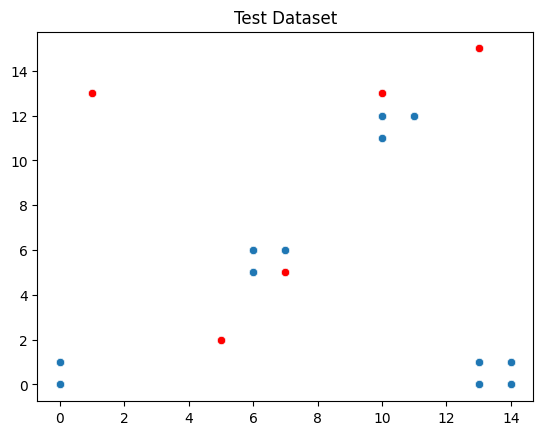

<Figure size 640x480 with 0 Axes>

In [136]:
#weights=qbm.H.θ
import seaborn as sns

#training_data=numpy.expand_dims(training_data[:,0],axis=1)
outliers = qbm.get_binary_outliers(
dataset=testing_dataset, outlier_index=CLUSTER+1)

#outliers=numpy.expand_dims(outliers[:,0],axis=1)
print(outliers)

points = qbm.get_binary_cluster_points(
dataset=testing_dataset, cluster_index=CLUSTER )

#points=numpy.expand_dims(points[:,0],axis=1)
#print(points)
predict_points_cluster = np.zeros(len(points), dtype=int)
predict_points_outliers = np.zeros(len(outliers), dtype=int)
qbm.calculate_outlier_threshold(.95)
print("Outlier threshold: ", qbm.outlier_threshold)
print("Calculate outlier Energy")

testing_data, testing_labels = split_dataset_labels(testing_dataset)
#testing_data=numpy.expand_dims(testing_data[:,0],axis=1)

outlier_energy = []
for index, outlier in enumerate(tqdm(outliers), 0):
    outlier = np.reshape(outlier, (qbm.dim_input))
    predict_points_outliers[index], this_outlier_energy = qbm.predict_point_as_outlier(
        outlier)
    outlier_energy.append(this_outlier_energy)
outlier_energy = np.array(outlier_energy)

o = outlier_energy.reshape((outlier_energy.shape[0]))

print("Calculate cluster energy")
cluster_point_energy = []

for index, point in enumerate(tqdm(points), 0):
    point = np.reshape(point, (qbm.dim_input))
    predict_points_cluster[index], this_cluster_point_energy = qbm.predict_point_as_outlier(
        point)
    cluster_point_energy.append(this_cluster_point_energy)
cluster_point_energy = np.array(cluster_point_energy)

c = cluster_point_energy.reshape((cluster_point_energy.shape[0]))

title='test'
#qbmqsp.src.utils.save_output(title="cluster_" + title, object=c)
#QBM.plot_energy_diff([o, c], qbm.outlier_threshold, title + ".pdf")

#QBM.plot_hist(c, o, qbm.outlier_threshold, "qbm_hist" + ".pdf")

########## OUTLIER CLASSIFICATION ##########
print('Outlier classification: Results...')
predict_points = np.concatenate(
    (predict_points_cluster, predict_points_outliers))

print("Predicted points test: ", predict_points)

true_points = np.concatenate(
    (np.zeros_like(cluster_point_energy), np.ones_like(outlier_energy)))

accuracy, precision, recall = accuracy_score(true_points, predict_points), precision_score(
    true_points, predict_points), recall_score(true_points, predict_points)
f1 = f1_score(true_points, predict_points)
tn, fp, fn, tp = confusion_matrix(
    true_points, predict_points, labels=[0, 1]).ravel()

print(f'Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1-Score: {f1}, \nNum True Negative: {tn}, Num False Negative: {fn}, Num True Positive: {tp}, Num False Positive: {fp}')

#print(f'Wallclock time: {(end-start):.2f} seconds')

print("Outlier threshold: ", qbm.outlier_threshold)
print("Average clusterpoint energy: ", np.average(cluster_point_energy))
print("Outlier energy: ", outlier_energy)
plt.figure()
plt.title('Test Dataset')
lab=3
sns.scatterplot(x=testing_data[:,0],y=testing_data[:,1])
sns.scatterplot(c='r',x=testing_data[:,0][testing_labels>lab],y=testing_data[:,1][testing_labels>lab])
plt.figure()



In [85]:
weights=[]
for b in [12,15,17,20,23,26,29,31]:
    weights.append(np.load(f'./weights_8_1_un_5_epochs_b{b}.npz')['arr_0'])

In [86]:
f1s=[]
for i in range(len(weights)):
    f1=[]
    for k in range(len(weights[i])):
        qbm.H.θ=weights[i][k]
        p,r,f=evaluate_qbm(qbm,testing_dataset,cluster=3,plot=False)
        f1.append(f)
    f1s.append(f1)
    

    

Outlier threshold:  -0.04186918483044033
Calculate outlier Energy


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 623.76it/s]


Calculate cluster energy


100%|███████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 744.55it/s]


Outlier classification: Results...
Predicted points test:  [0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1]
Accuracy: 0.9158415841584159, Precision: 0.08571428571428572, Recall: 0.6, F1-Score: 0.15, 
Num True Negative: 367, Num F

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 705.52it/s]


Calculate cluster energy


100%|███████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 808.61it/s]


Outlier classification: Results...
Predicted points test:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1]
Accuracy: 0.948019801980198, Precision: 0.13636363636363635, Recall: 0.6, F1-Score: 0.2222222222222222, 
Num True Negativ

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 674.07it/s]


Calculate cluster energy


100%|███████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 879.00it/s]


Outlier classification: Results...
Predicted points test:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1]
Accuracy: 0.9529702970297029, Precision: 0.15, Recall: 0.6, F1-Score: 0.24, 
Num True Negative: 382, Num False Negative: 

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 765.16it/s]


Calculate cluster energy


100%|███████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 919.93it/s]


Outlier classification: Results...
Predicted points test:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1]
Accuracy: 0.9579207920792079, Precision: 0.16666666666666666, Recall: 0.6, F1-Score: 0.2608695652173913, 
Num True Negati

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 511.30it/s]


Calculate cluster energy


100%|███████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 870.83it/s]


Outlier classification: Results...
Predicted points test:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1]
Accuracy: 0.9529702970297029, Precision: 0.15, Recall: 0.6, F1-Score: 0.24, 
Num True Negative: 382, Num False Negative: 

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 615.51it/s]


Calculate cluster energy


100%|███████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 820.40it/s]


Outlier classification: Results...
Predicted points test:  [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0
 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1]
Accuracy: 0.9257425742574258, Precision: 0.0967741935483871, Recall: 0.6, F1-Score: 0.16666666666666666, 
Num True Negati

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 651.47it/s]


Calculate cluster energy


100%|███████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 906.56it/s]


Outlier classification: Results...
Predicted points test:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1]
Accuracy: 0.9554455445544554, Precision: 0.15789473684210525, Recall: 0.6, F1-Score: 0.25, 
Num True Negative: 383, Num F

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 583.29it/s]


Calculate cluster energy


100%|███████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 911.49it/s]


Outlier classification: Results...
Predicted points test:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1]
Accuracy: 0.9554455445544554, Precision: 0.15789473684210525, Recall: 0.6, F1-Score: 0.25, 
Num True Negative: 383, Num F

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 666.88it/s]


Calculate cluster energy


100%|███████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 845.59it/s]


Outlier classification: Results...
Predicted points test:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1]
Accuracy: 0.9455445544554455, Precision: 0.13043478260869565, Recall: 0.6, F1-Score: 0.21428571428571427, 
Num True Negat

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 525.96it/s]


Calculate cluster energy


100%|███████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 789.66it/s]


Outlier classification: Results...
Predicted points test:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1]
Accuracy: 0.9554455445544554, Precision: 0.15789473684210525, Recall: 0.6, F1-Score: 0.25, 
Num True Negative: 383, Num F

100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 1633.68it/s]


Calculate cluster energy


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1330.37it/s]


Outlier classification: Results...
Predicted points test:  [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1]
Accuracy: 0.9232673267326733, Precision: 0.09375, Recall: 0.6, F1-Score: 0.16216216216216217, 
Num True Negative: 370, Nu

100%|████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<?, ?it/s]


Calculate cluster energy


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1211.59it/s]


Outlier classification: Results...
Predicted points test:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1]
Accuracy: 0.9381188118811881, Precision: 0.11538461538461539, Recall: 0.6, F1-Score: 0.1935483870967742, 
Num True Negati

100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 2926.53it/s]


Calculate cluster energy


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1273.18it/s]


Outlier classification: Results...
Predicted points test:  [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1]
Accuracy: 0.9405940594059405, Precision: 0.12, Recall: 0.6, F1-Score: 0.2, 
Num True Negative: 377, Num False Negative: 2

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 786.10it/s]


Calculate cluster energy


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1241.91it/s]


Outlier classification: Results...
Predicted points test:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1]
Accuracy: 0.9678217821782178, Precision: 0.21428571428571427, Recall: 0.6, F1-Score: 0.3157894736842105, 
Num True Negati

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 989.74it/s]


Calculate cluster energy


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1177.96it/s]


Outlier classification: Results...
Predicted points test:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1]
Accuracy: 0.9529702970297029, Precision: 0.15, Recall: 0.6, F1-Score: 0.24, 
Num True Negative: 382, Num False Negative: 

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 725.31it/s]


Calculate cluster energy


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1399.31it/s]


Outlier classification: Results...
Predicted points test:  [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0
 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1]
Accuracy: 0.9331683168316832, Precision: 0.10714285714285714, Recall: 0.6, F1-Score: 0.18181818181818182, 
Num True Negat

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 847.61it/s]


Calculate cluster energy


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1180.49it/s]


Outlier classification: Results...
Predicted points test:  [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1]
Accuracy: 0.9381188118811881, Precision: 0.11538461538461539, Recall: 0.6, F1-Score: 0.1935483870967742, 
Num True Negati

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 651.90it/s]


Calculate cluster energy


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1244.09it/s]


Outlier classification: Results...
Predicted points test:  [0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1]
Accuracy: 0.9331683168316832, Precision: 0.10714285714285714, Recall: 0.6, F1-Score: 0.18181818181818182, 
Num True Negat

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 715.43it/s]


Calculate cluster energy


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1170.97it/s]


Outlier classification: Results...
Predicted points test:  [0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1]
Accuracy: 0.943069306930693, Precision: 0.125, Recall: 0.6, F1-Score: 0.20689655172413793, 
Num True Negative: 378, Num F

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 833.69it/s]


Calculate cluster energy


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1181.19it/s]


Outlier classification: Results...
Predicted points test:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1]
Accuracy: 0.9504950495049505, Precision: 0.14285714285714285, Recall: 0.6, F1-Score: 0.23076923076923078, 
Num True Negat

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 717.66it/s]


Calculate cluster energy


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1050.21it/s]


Outlier classification: Results...
Predicted points test:  [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0]
Accuracy: 0.9381188118811881, Precision: 0.08333333333333333, Recall: 0.4, F1-Score: 0.13793103448275862, 
Num True Negat

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 904.06it/s]


Calculate cluster energy


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1329.94it/s]


Outlier classification: Results...
Predicted points test:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 1 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1]
Accuracy: 0.943069306930693, Precision: 0.125, Recall: 0.6, F1-Score: 0.20689655172413793, 
Num True Negative: 378, Num F

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 751.21it/s]


Calculate cluster energy


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1192.44it/s]


Outlier classification: Results...
Predicted points test:  [0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1]
Accuracy: 0.9405940594059405, Precision: 0.12, Recall: 0.6, F1-Score: 0.2, 
Num True Negative: 377, Num False Negative: 2

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 780.07it/s]


Calculate cluster energy


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1150.76it/s]


Outlier classification: Results...
Predicted points test:  [0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1]
Accuracy: 0.943069306930693, Precision: 0.125, Recall: 0.6, F1-Score: 0.20689655172413793, 
Num True Negative: 378, Num F

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 730.08it/s]


Calculate cluster energy


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1089.12it/s]


Outlier classification: Results...
Predicted points test:  [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1]
Accuracy: 0.9653465346534653, Precision: 0.2, Recall: 0.6, F1-Score: 0.3, 
Num True Negative: 387, Num False Negative: 2,

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 707.54it/s]


Calculate cluster energy


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1130.59it/s]


Outlier classification: Results...
Predicted points test:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1]
Accuracy: 0.9331683168316832, Precision: 0.07692307692307693, Recall: 0.4, F1-Score: 0.12903225806451613, 
Num True Negat

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 624.25it/s]


Calculate cluster energy


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1108.06it/s]


Outlier classification: Results...
Predicted points test:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1]
Accuracy: 0.9579207920792079, Precision: 0.16666666666666666, Recall: 0.6, F1-Score: 0.2608695652173913, 
Num True Negati

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 821.45it/s]


Calculate cluster energy


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1299.23it/s]


Outlier classification: Results...
Predicted points test:  [0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1]
Accuracy: 0.9405940594059405, Precision: 0.12, Recall: 0.6, F1-Score: 0.2, 
Num True Negative: 377, Num False Negative: 2

100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 3316.18it/s]


Calculate cluster energy


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1252.18it/s]


Outlier classification: Results...
Predicted points test:  [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1]
Accuracy: 0.9603960396039604, Precision: 0.17647058823529413, Recall: 0.6, F1-Score: 0.2727272727272727, 
Num True Negati

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 714.63it/s]


Calculate cluster energy


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1196.48it/s]


Outlier classification: Results...
Predicted points test:  [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1]
Accuracy: 0.9405940594059405, Precision: 0.12, Recall: 0.6, F1-Score: 0.2, 
Num True Negative: 377, Num False Negative: 2

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 929.75it/s]


Calculate cluster energy


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1176.43it/s]


Outlier classification: Results...
Predicted points test:  [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0
 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1]
Accuracy: 0.9158415841584159, Precision: 0.06060606060606061, Recall: 0.4, F1-Score: 0.10526315789473684, 
Num True Negat

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 744.33it/s]


Calculate cluster energy


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1164.54it/s]


Outlier classification: Results...
Predicted points test:  [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1
 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1]
Accuracy: 0.9381188118811881, Precision: 0.11538461538461539, Recall: 0.6, F1-Score: 0.1935483870967742, 
Num True Negati

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 624.95it/s]


Calculate cluster energy


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1303.27it/s]


Outlier classification: Results...
Predicted points test:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1]
Accuracy: 0.9554455445544554, Precision: 0.15789473684210525, Recall: 0.6, F1-Score: 0.25, 
Num True Negative: 383, Num F

100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 1245.19it/s]


Calculate cluster energy


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1248.39it/s]


Outlier classification: Results...
Predicted points test:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1]
Accuracy: 0.9455445544554455, Precision: 0.13043478260869565, Recall: 0.6, F1-Score: 0.21428571428571427, 
Num True Negat

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 704.57it/s]


Calculate cluster energy


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1258.78it/s]


Outlier classification: Results...
Predicted points test:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1]
Accuracy: 0.9579207920792079, Precision: 0.16666666666666666, Recall: 0.6, F1-Score: 0.2608695652173913, 
Num True Negati

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 786.57it/s]


Calculate cluster energy


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1296.56it/s]


Outlier classification: Results...
Predicted points test:  [0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
Accuracy: 0.9455445544554455, Precision: 0.05263157894736842, Recall: 0.2, F1-Score: 0.08333333333333333, 
Num True Negat

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 745.89it/s]


Calculate cluster energy


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1213.84it/s]


Outlier classification: Results...
Predicted points test:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0
 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1]
Accuracy: 0.9108910891089109, Precision: 0.05714285714285714, Recall: 0.4, F1-Score: 0.1, 
Num True Negative: 366, Num Fa

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 910.93it/s]


Calculate cluster energy


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1292.06it/s]


Outlier classification: Results...
Predicted points test:  [0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1]
Accuracy: 0.9405940594059405, Precision: 0.12, Recall: 0.6, F1-Score: 0.2, 
Num True Negative: 377, Num False Negative: 2

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 625.03it/s]


Calculate cluster energy


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1271.59it/s]


Outlier classification: Results...
Predicted points test:  [0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1]
Accuracy: 0.9356435643564357, Precision: 0.1111111111111111, Recall: 0.6, F1-Score: 0.1875, 
Num True Negative: 375, Num 

100%|████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<?, ?it/s]


Calculate cluster energy


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1324.35it/s]


Outlier classification: Results...
Predicted points test:  [0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1]
Accuracy: 0.9356435643564357, Precision: 0.1111111111111111, Recall: 0.6, F1-Score: 0.1875, 
Num True Negative: 375, Num 

In [87]:
np.max(f1s,axis=1)

tensor([0.26086957, 0.25      , 0.31578947, 0.23076923, 0.3       ,
        0.27272727, 0.26086957, 0.2       ], requires_grad=True)

Text(0, 0.5, 'Max_F1 Score')

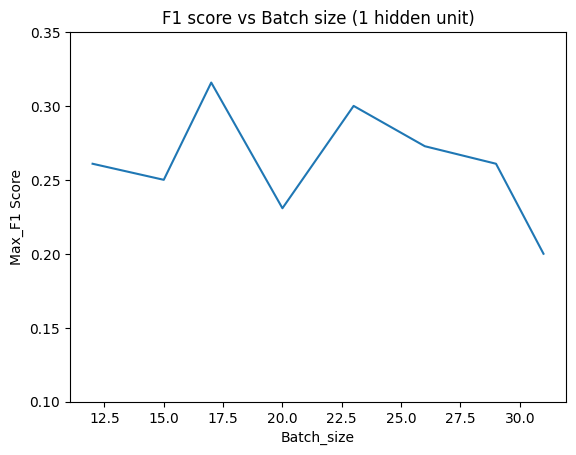

In [94]:
plt.plot([12,15,17,20,23,26,29,31],np.max(f1s,axis=1))
plt.ylim(0.1,0.35)
plt.title('F1 score vs Batch size (1 hidden unit)')
plt.xlabel('Batch_size')
plt.ylabel('Max_F1 Score')

In [89]:
n_hidden_units=2
n_visible=8
n_qubits = n_visible+n_hidden_units

restricted=False
h = generate_pauli_strings_tfim(n_qubits,n_visible,restricted)
print(h)
nparams = len(h)

θ_init = np.random.rand(nparams)/nparams#np.loadtxt('./weights_7_3_un.txt')
enc = 'general'
δ = 0.3
polydeg = 10
β = 1.0
learning_rate = 0.005
epochs = 4


dev_name='default.qubit'
#dev_name='lightning.qubit'

qbm = QBM(training_data,h, θ_init, enc, δ, polydeg, β,n_hidden_units,epochs,restricted)


['ZIIIIIIIII', 'IZIIIIIIII', 'IIZIIIIIII', 'IIIZIIIIII', 'IIIIZIIIII', 'IIIIIZIIII', 'IIIIIIZIII', 'IIIIIIIZII', 'IIIIIIIIZI', 'IIIIIIIIIZ', 'ZZIIIIIIII', 'ZIZIIIIIII', 'ZIIZIIIIII', 'ZIIIZIIIII', 'ZIIIIZIIII', 'ZIIIIIZIII', 'ZIIIIIIZII', 'ZIIIIIIIZI', 'ZIIIIIIIIZ', 'IZZIIIIIII', 'IZIZIIIIII', 'IZIIZIIIII', 'IZIIIZIIII', 'IZIIIIZIII', 'IZIIIIIZII', 'IZIIIIIIZI', 'IZIIIIIIIZ', 'IIZZIIIIII', 'IIZIZIIIII', 'IIZIIZIIII', 'IIZIIIZIII', 'IIZIIIIZII', 'IIZIIIIIZI', 'IIZIIIIIIZ', 'IIIZZIIIII', 'IIIZIZIIII', 'IIIZIIZIII', 'IIIZIIIZII', 'IIIZIIIIZI', 'IIIZIIIIIZ', 'IIIIZZIIII', 'IIIIZIZIII', 'IIIIZIIZII', 'IIIIZIIIZI', 'IIIIZIIIIZ', 'IIIIIZZIII', 'IIIIIZIZII', 'IIIIIZIIZI', 'IIIIIZIIIZ', 'IIIIIIZZII', 'IIIIIIZIZI', 'IIIIIIZIIZ', 'IIIIIIIZZI', 'IIIIIIIZIZ']

Starting MATLAB engine.. Done.


Stopping MATLAB engine ... Done.



In [90]:
weights=[]
for b in [17,20,23,26,29,31]:
    weights.append(np.load(f'./weights_8_2_un_5_epochs_b{17}.npz')['arr_0'])

In [91]:
f1_2s=[]
for i in range(len(weights)):
    f1=[]
    for k in range(len(weights[i])):
        qbm.H.θ=weights[i][k]
        p,r,f=evaluate_qbm(qbm,testing_dataset,cluster=3,plot=False)
        f1.append(f)
    f1_2s.append(f1)
    

Outlier threshold:  0.010065161041152237
Calculate outlier Energy


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 713.49it/s]


Calculate cluster energy


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1365.40it/s]


Outlier classification: Results...
Predicted points test:  [0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 1 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1]
Accuracy: 0.905940594059406, Precision: 0.07692307692307693, Recall: 0.6, F1-Score: 0.13636363636363635, 
Num True Negati

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 714.24it/s]


Calculate cluster energy


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1044.09it/s]


Outlier classification: Results...
Predicted points test:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1]
Accuracy: 0.9504950495049505, Precision: 0.14285714285714285, Recall: 0.6, F1-Score: 0.23076923076923078, 
Num True Negat

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 765.24it/s]


Calculate cluster energy


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1266.90it/s]


Outlier classification: Results...
Predicted points test:  [0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1]
Accuracy: 0.9405940594059405, Precision: 0.12, Recall: 0.6, F1-Score: 0.2, 
Num True Negative: 377, Num False Negative: 2

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 703.34it/s]


Calculate cluster energy


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1189.82it/s]


Outlier classification: Results...
Predicted points test:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1]
Accuracy: 0.9504950495049505, Precision: 0.14285714285714285, Recall: 0.6, F1-Score: 0.23076923076923078, 
Num True Negat

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 826.85it/s]


Calculate cluster energy


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1015.80it/s]


Outlier classification: Results...
Predicted points test:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1]
Accuracy: 0.9504950495049505, Precision: 0.14285714285714285, Recall: 0.6, F1-Score: 0.23076923076923078, 
Num True Negat

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 828.29it/s]


Calculate cluster energy


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1057.74it/s]


Outlier classification: Results...
Predicted points test:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0
 1 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1]
Accuracy: 0.9084158415841584, Precision: 0.07894736842105263, Recall: 0.6, F1-Score: 0.13953488372093023, 
Num True Negat

100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 1212.72it/s]


Calculate cluster energy


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1226.36it/s]


Outlier classification: Results...
Predicted points test:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1]
Accuracy: 0.9579207920792079, Precision: 0.16666666666666666, Recall: 0.6, F1-Score: 0.2608695652173913, 
Num True Negati

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 760.50it/s]


Calculate cluster energy


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1266.06it/s]


Outlier classification: Results...
Predicted points test:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1]
Accuracy: 0.9653465346534653, Precision: 0.2, Recall: 0.6, F1-Score: 0.3, 
Num True Negative: 387, Num False Negative: 2,

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 350.33it/s]


Calculate cluster energy


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1344.09it/s]


Outlier classification: Results...
Predicted points test:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1]
Accuracy: 0.9504950495049505, Precision: 0.14285714285714285, Recall: 0.6, F1-Score: 0.23076923076923078, 
Num True Negat

100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 1563.64it/s]


Calculate cluster energy


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1155.08it/s]


Outlier classification: Results...
Predicted points test:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1]
Accuracy: 0.9529702970297029, Precision: 0.15, Recall: 0.6, F1-Score: 0.24, 
Num True Negative: 382, Num False Negative: 

100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 1011.02it/s]


Calculate cluster energy


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1032.01it/s]


Outlier classification: Results...
Predicted points test:  [0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1]
Accuracy: 0.9331683168316832, Precision: 0.10714285714285714, Recall: 0.6, F1-Score: 0.18181818181818182, 
Num True Negat

100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 1181.89it/s]


Calculate cluster energy


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1258.67it/s]


Outlier classification: Results...
Predicted points test:  [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1]
Accuracy: 0.9554455445544554, Precision: 0.15789473684210525, Recall: 0.6, F1-Score: 0.25, 
Num True Negative: 383, Num F

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 977.97it/s]


Calculate cluster energy


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1199.09it/s]


Outlier classification: Results...
Predicted points test:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1]
Accuracy: 0.9579207920792079, Precision: 0.16666666666666666, Recall: 0.6, F1-Score: 0.2608695652173913, 
Num True Negati

100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 1144.48it/s]


Calculate cluster energy


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1121.40it/s]


Outlier classification: Results...
Predicted points test:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1]
Accuracy: 0.9455445544554455, Precision: 0.13043478260869565, Recall: 0.6, F1-Score: 0.21428571428571427, 
Num True Negat

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 897.79it/s]


Calculate cluster energy


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1065.35it/s]


Outlier classification: Results...
Predicted points test:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1]
Accuracy: 0.9504950495049505, Precision: 0.14285714285714285, Recall: 0.6, F1-Score: 0.23076923076923078, 
Num True Negat

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 837.59it/s]


Calculate cluster energy


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1142.26it/s]


Outlier classification: Results...
Predicted points test:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1]
Accuracy: 0.9257425742574258, Precision: 0.0967741935483871, Recall: 0.6, F1-Score: 0.16666666666666666, 
Num True Negati

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 706.16it/s]


Calculate cluster energy


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1197.87it/s]


Outlier classification: Results...
Predicted points test:  [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1]
Accuracy: 0.9381188118811881, Precision: 0.11538461538461539, Recall: 0.6, F1-Score: 0.1935483870967742, 
Num True Negati

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 680.36it/s]


Calculate cluster energy


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1210.43it/s]


Outlier classification: Results...
Predicted points test:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1]
Accuracy: 0.9504950495049505, Precision: 0.14285714285714285, Recall: 0.6, F1-Score: 0.23076923076923078, 
Num True Negat

100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 1213.84it/s]


Calculate cluster energy


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1376.69it/s]


Outlier classification: Results...
Predicted points test:  [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1]
Accuracy: 0.9331683168316832, Precision: 0.10714285714285714, Recall: 0.6, F1-Score: 0.18181818181818182, 
Num True Negat

100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 1149.38it/s]


Calculate cluster energy


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1349.97it/s]


Outlier classification: Results...
Predicted points test:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1]
Accuracy: 0.9455445544554455, Precision: 0.13043478260869565, Recall: 0.6, F1-Score: 0.21428571428571427, 
Num True Negat

100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 1103.36it/s]


Calculate cluster energy


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1158.57it/s]


Outlier classification: Results...
Predicted points test:  [0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1
 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1
 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0
 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1]
Accuracy: 0.900990099009901, Precision: 0.07317073170731707, Recall: 0.6, F1-Score: 0.13043478260869565, 
Num True Negati

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 829.80it/s]


Calculate cluster energy


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1208.36it/s]


Outlier classification: Results...
Predicted points test:  [0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0
 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0
 0 0 1 1 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1]
Accuracy: 0.8960396039603961, Precision: 0.06976744186046512, Recall: 0.6, F1-Score: 0.125, 
Num True Negative: 359, Num 

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 807.44it/s]


Calculate cluster energy


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1238.44it/s]


Outlier classification: Results...
Predicted points test:  [0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1]
Accuracy: 0.9381188118811881, Precision: 0.11538461538461539, Recall: 0.6, F1-Score: 0.1935483870967742, 
Num True Negati

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 743.83it/s]


Calculate cluster energy


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1072.59it/s]


Outlier classification: Results...
Predicted points test:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1]
Accuracy: 0.9603960396039604, Precision: 0.17647058823529413, Recall: 0.6, F1-Score: 0.2727272727272727, 
Num True Negati

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 900.57it/s]


Calculate cluster energy


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1181.37it/s]


Outlier classification: Results...
Predicted points test:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1]
Accuracy: 0.9554455445544554, Precision: 0.15789473684210525, Recall: 0.6, F1-Score: 0.25, 
Num True Negative: 383, Num F

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 902.23it/s]


Calculate cluster energy


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1075.02it/s]


Outlier classification: Results...
Predicted points test:  [0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1]
Accuracy: 0.9356435643564357, Precision: 0.1111111111111111, Recall: 0.6, F1-Score: 0.1875, 
Num True Negative: 375, Num 

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 891.61it/s]


Calculate cluster energy


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1203.45it/s]


Outlier classification: Results...
Predicted points test:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1]
Accuracy: 0.943069306930693, Precision: 0.125, Recall: 0.6, F1-Score: 0.20689655172413793, 
Num True Negative: 378, Num F

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 845.63it/s]


Calculate cluster energy


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1123.90it/s]


Outlier classification: Results...
Predicted points test:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1]
Accuracy: 0.9529702970297029, Precision: 0.15, Recall: 0.6, F1-Score: 0.24, 
Num True Negative: 382, Num False Negative: 

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 993.35it/s]


Calculate cluster energy


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1342.11it/s]


Outlier classification: Results...
Predicted points test:  [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1]
Accuracy: 0.9356435643564357, Precision: 0.1111111111111111, Recall: 0.6, F1-Score: 0.1875, 
Num True Negative: 375, Num 

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 947.09it/s]


Calculate cluster energy


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1287.55it/s]

Outlier classification: Results...
Predicted points test:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1]
Accuracy: 0.9455445544554455, Precision: 0.13043478260869565, Recall: 0.6, F1-Score: 0.21428571428571427, 
Num True Negat

Text(0, 0.5, 'Max_F1 Score')

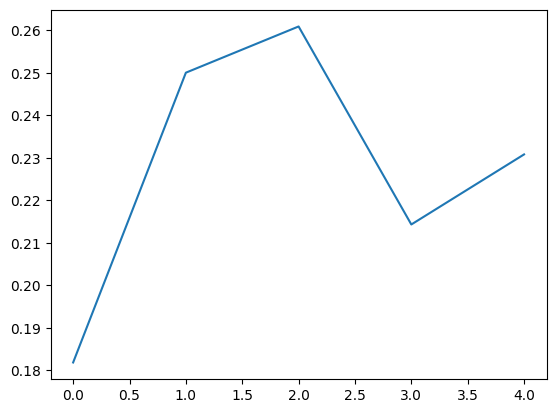

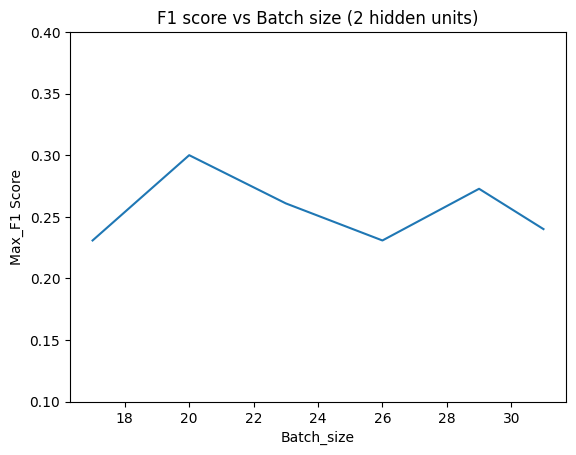

In [92]:
plt.plot(f1_2s[2])
plt.figure()
plt.plot([17,20,23,26,29,31],np.max(f1_2s,axis=1))
plt.ylim(0.1,0.40)
plt.title('F1 score vs Batch size (2 hidden units)')
plt.xlabel('Batch_size')
plt.ylabel('Max_F1 Score')

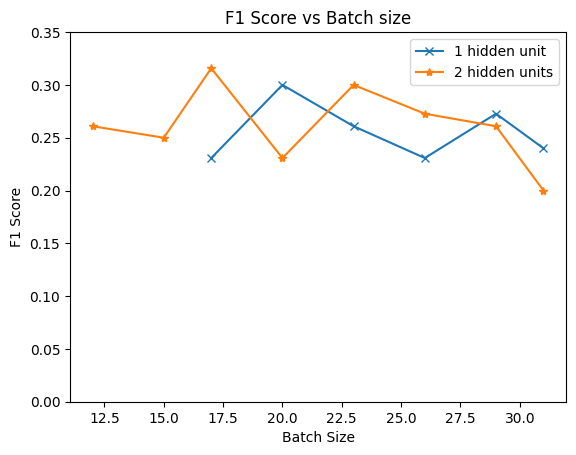

In [100]:
plt.plot([17,20,23,26,29,31],np.max(f1_2s,axis=1), marker='x', label='1 hidden unit')
plt.plot([12,15,17,20,23,26,29,31],np.max(f1s,axis=1), marker='*' , label='2 hidden units')
plt.ylim(0,0.35)
plt.title('F1 Score vs Batch size')
plt.ylabel('F1 Score')
plt.xlabel('Batch Size')
plt.legend()